# Averaging And Sorting Data

### Finding The Averages

In [97]:
import pandas as pd
import numpy as np
from os.path import exists
from functools import reduce
import datetime
import warnings
warnings.filterwarnings("ignore")#there are some warnings that show up from pandas that don't effect us, so we just mute them

#authored by Tom Odem on 12 November 2023
#computes the averages of data over a set increments of time for users, then merges averages with respective depression measurements
def get_and_avg_data(avg_over_n_days = 7):
#avg_over_n_days: integer value of the amount of days to compute averages over. defaults to 7, which computes weekly averages
    
    users_df = pd.read_csv('user_information.csv') #read the user_information.csv file to get user ids, depression scores, etc
    n_days_df = pd.DataFrame(columns=['user_id','avg_step','avg_sleep','avg_drink', 'avg_eat','avg_care']) #initialize the dataframe that will hold averages over n days

    #go through all users in user_information.csv
    for user in users_df['user_id']:
        if(exists('user_data/data_'+str(user)+'.csv')): #if the user's data csv exists then open it and continue
            user_df = pd.read_csv('user_data/data_'+str(user)+'.csv')
            
            #find daily step count
            user_df['client_time']= [pd.to_datetime(i).date() for i in user_df['client_time']]#turn the datetime entries into just dates
            steps= user_df.groupby(['client_time'])['step'].max().reset_index().rename(columns={'client_time':'date'}).astype({'date':object})#compute the daily step count by just taking the maximum step count everyday, rename client_time to date so we can merge with others, force date to be object for merging
            
            if(exists('user_tags/'+str(user)+'.csv')): #if the user's tags csv exists then open it and continue
                u = pd.read_csv('user_tags/'+str(user)+'.csv')
                u = u.drop(columns=['end'])


                #find daily sleep time
                #finds the time the user wakes up everyday
                wakeup_time = u.loc[(u['labelName'] == 'Wake up')]
                wakeup_time['start'] = [pd.to_datetime(t)  for t in wakeup_time['start']]
                wakeup_time['date']= [pd.to_datetime(t).date() for t in wakeup_time['start']]
                wakeup_time['hour']= [pd.to_datetime(t).time() for t in wakeup_time['start']]

                #finds the time the user went to sleep everyday
                sleep_time = u.loc[(u['labelName'] == 'Sleep')]
                sleep_time['start'] = [pd.to_datetime(t) for t in sleep_time['start']]
                sleep_time['date']= [(pd.to_datetime(t)+ pd.Timedelta(days=1)).date() for t in sleep_time['start']]
                sleep_time['hour']= [pd.to_datetime(t).time() for t in sleep_time['start']]
                
                #computes the amount of time the user slept daily
                r = pd.merge(wakeup_time, sleep_time, on ='date')
                r['start_y'] = pd.to_datetime(r['start_y'])
                r['start_x'] = pd.to_datetime(r['start_x'])
                r['sleeptime'] = (-1*(r['start_y'] - r['start_x']).astype('timedelta64[m]'))/60 #find the difference between when they woke up from when they went to sleep in hours
                r = r[['sleeptime','date']].groupby('date').mean().reset_index().astype({'date':object})#we only need the date and the sleeptime, we rest the index to change it back 
                                                                                                        #to a dataframe, and we want to force teh date to be of type object so that we can always merge even if there are no entries
                
                #find daily number of times the user drank
                drinktime = u.loc[(u['labelName'] == 'Drink')] #we only want the entries that correlate to drinking
                drinktime['date'] = [pd.to_datetime(t).date() for t in drinktime['start']] #gives us the date that the drink happened, since we do not need to know the exact time
                drinktime = drinktime.rename(columns={'labelName':'drinktime'}).groupby('date').count().drop(['start'], axis = 1).reset_index().astype({'date':object}) #finds the number of times the user drank a day by grouping by the date, we drop start becase
                                                                                                                                                                        #we only need to know the date, we reset the index to turn it back into a dataframe, and we force date to be object for merging
                
                #find daily number of times the user ate
                eattime = u.loc[(u['labelName'] == 'Eat')] #we only want the entries that correlate to eating
                eattime['date'] = [pd.to_datetime(t).date() for t in eattime['start']] #gives us the date that the eat happened, since we do not need to know the exact time
                eattime = eattime.rename(columns={'labelName':'eattime'}).groupby('date').count().drop(['start'], axis = 1).reset_index().astype({'date':object}) #finds the number of times the user ate a day by grouping by the date, we drop start becase
                                                                                                                                                                #we only need to know the date, we reset the index to turn it back into a dataframe, and we force date to be object for merging
                
                #find daily number of times the user performed and act of self care
                self_care = u.loc[(u['labelName'] == 'Take shower') | (u['labelName'] == 'Go to bathroom')] #we only want the entries that correlate to self care
                self_care['date'] = [pd.to_datetime(t).date() for t in self_care['start']] #gives us the date that the self care happened, since we do not need to know the exact time
                self_care = self_care.rename(columns={'labelName':'selfcare'}).groupby('date').count().drop(['start'], axis = 1).reset_index().astype({'date':object}) #finds the number of times the user self cared a day by grouping by the date, we drop start becase
                                                                                                                                                                        #we only need to know the date, we reset the index to turn it back into a dataframe, and we force date to be object for merging

                #merge all of the daily counts on time
                data_frames = [r,drinktime,eattime,self_care,steps] #the dataframes to be merged
                data_by_day_df = reduce(lambda  left,right: pd.merge(left,right,on=['date'],how='outer'), data_frames) #pd.merge can only merge two at a time, so we have to run merge over all of the dataframes

                max_date = data_by_day_df['date'].max() #find the latest date in the dataframe

                current_date = data_by_day_df['date'].min() #we start at the earliest date in the dataframe

                
                #take averages over avg_over_n_days incriments from the first day to the last day
                while current_date < max_date: #while we haven't reached the last day
                    n_days_from_current_date = current_date+datetime.timedelta(days=avg_over_n_days) #find the day that is avg_over_n_days away from the current date

                    range = (data_by_day_df['date'] >= current_date) & (data_by_day_df['date'] < n_days_from_current_date) #define the range of dates we select from data_by_day_df 

                    #compute the averages of each activity within the given range
                    avg_sleep = np.mean(data_by_day_df.loc[range]['sleeptime'])
                    avg_drink = np.mean(data_by_day_df.loc[range]['drinktime'])
                    avg_eat = np.mean(data_by_day_df.loc[range]['eattime'])
                    avg_care = np.mean(data_by_day_df.loc[range]['selfcare'])
                    avg_step = np.mean(data_by_day_df.loc[range]['step'])

                    #add the averages to predic_df
                    temp = pd.DataFrame([[user,avg_step, avg_sleep, avg_drink, avg_eat, avg_care]], columns=['user_id','avg_step','avg_sleep','avg_drink', 'avg_eat', 'avg_care'])
                    n_days_df = pd.concat([n_days_df, temp])


                    current_date = n_days_from_current_date #our range did not include the day avg_over_n_days away, so that day is now our current day to start from


                

                
        
            else:
                print(f'no user_tags: {user}') #the tags csv was missing for this user
        else:
            print(f'no user_data: {user}') #the data csv was missing for this user


    averages_df = pd.merge(n_days_df, users_df[['user_id','depression_class', 'depression_score']], on='user_id').set_index('user_id') #merge the averages with their respective depression class and deppression score
    return averages_df

In [98]:
# example, getting averages over an increment of 5 days
averages_df = get_and_avg_data(5)
print(len(averages_df))

no user_tags: 520
no user_tags: 532
no user_tags: 503
no user_tags: 503
no user_tags: 523
no user_tags: 544
no user_tags: 529
no user_tags: 661
no user_tags: 658
no user_tags: 664
no user_tags: 634
no user_tags: 507
no user_tags: 547
no user_tags: 501
no user_tags: 668
no user_tags: 662
1510


In [99]:
#display the dataframe
#averages_df


display(averages_df)
max_value_normal = averages_df.loc[averages_df['depression_class'] == 'Normal', 'depression_score'].max()
print("Max value for 'Normal' class:", max_value_normal)

#Make Nan values 0 to help with calculations later on
averages_df['avg_sleep'].fillna(0, inplace=True)
averages_df['avg_step'].fillna(0, inplace=True)

display(averages_df['avg_step'] <= 6000)



,avg_step,avg_sleep,avg_drink,avg_eat,avg_care,depression_class,depression_score
user_id,,,,,,,
519,691.000000,NaN,NaN,3.000000,NaN,Moderate,0.5
519,3479.400000,21.923611,NaN,2.000000,1.00,Moderate,0.5
519,3947.400000,22.597457,NaN,2.800000,NaN,Moderate,0.5
519,4384.200000,22.111404,NaN,2.800000,1.00,Moderate,0.5
519,2681.000000,NaN,NaN,2.333333,1.00,Moderate,0.5
...,...,...,...,...,...,...,...
655,6417.600000,NaN,NaN,1.800000,1.20,Normal,0.0
655,8515.333333,NaN,NaN,2.000000,2.00,Normal,0.0
655,5010.800000,NaN,NaN,1.750000,2.50,Normal,0.0


Max value for 'Normal' class: 0.25


user_id
519     True
519     True
519     True
519     True
519     True
       ...  
655    False
655    False
655     True
655     True
655     True
Name: avg_step, Length: 1510, dtype: bool

#

# SVM Depression Detection

An SVM is utilized for detecting depression in users, considering three key factors:

- **Sleep Duration:** If the user sleeps for *>= 10 hours a day* on average.

- **Depression Score:** If the user has a depression score of *0.25 or higher*. This threshold is determined by finding the maximum depression score for a user with a level of 'Normal' depression.

- **Average Daily Steps:** If the user averages *less than 6000 steps a day*. This criterion is based on a study conducted on Korean seniors. The dataset used in the study consisted of people on average 10 years younger, so the steps requirements were adjusted to accommodate the older people in our dataset ([source](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5976873/)).

The SVM classifies a user as depressed if they pass the threshold with any **2 out of the 3 factors** listed above.



SVM Details:
Number of support vectors: 16


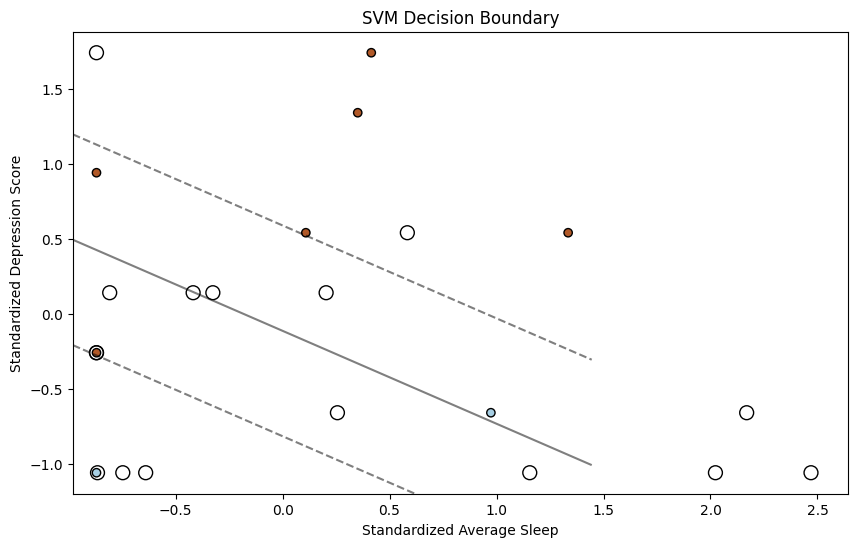


User with user_id 230.0 is classified as depressed.

User with user_id 232.0 is not classified as depressed.

User with user_id 476.0 is classified as depressed.

User with user_id 486.0 is classified as depressed.

User with user_id 492.0 is not classified as depressed.

User with user_id 495.0 is not classified as depressed.

User with user_id 496.0 is not classified as depressed.

User with user_id 499.0 is classified as depressed.

User with user_id 504.0 is classified as depressed.

User with user_id 505.0 is not classified as depressed.

User with user_id 508.0 is not classified as depressed.

User with user_id 512.0 is not classified as depressed.

User with user_id 516.0 is classified as depressed.

User with user_id 519.0 is not classified as depressed.

User with user_id 527.0 is classified as depressed.

User with user_id 530.0 is not classified as depressed.

User with user_id 536.0 is classified as depressed.

User with user_id 540.0 is classified as depressed.

User with

In [150]:
from sklearn import svm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Combine the user id's to include only unique ones
unique_users_df = averages_df[['avg_sleep', 'depression_score', 'avg_step']].groupby('user_id').mean().reset_index()

# Creating the three features for the SVM
avg_sleep_values = unique_users_df['avg_sleep'].values
depression_score_values = unique_users_df['depression_score'].values
avg_step_values = unique_users_df['avg_step'].values

# Define thresholds for sleep duration and depression score and average steps
sleep_threshold = 10.0
depression_score_threshold = 0.25
steps_threshold = 6000

# Count the number of conditions met for each user
conditions_met = ((avg_sleep_values >= sleep_threshold).astype(int) +
                  (depression_score_values >= depression_score_threshold).astype(int) +
                  (avg_step_values <= steps_threshold).astype(int))

# Classify a user as depressed if at least two out of three conditions are met
labels = (conditions_met >= 2).astype(int)

# Reshape the data to a 2D array
features = np.column_stack((avg_sleep_values, depression_score_values, avg_step_values))

# Standardize the features for better visualization
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, labels, test_size=0.2, random_state=42)

# Create an SVM classifier
classifier = svm.SVC(kernel='linear')

# Train the classifier
classifier.fit(X_train, y_train)

# Additional details
print("\nSVM Details:")
print("Number of support vectors:", len(classifier.support_vectors_))



# Plot the SVM decision boundary
plt.figure(figsize=(10, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.Paired, edgecolors='k')

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50), np.linspace(ylim[0], ylim[1], 50))
Z = classifier.decision_function(np.c_[xx.ravel(), yy.ravel(), np.zeros_like(xx.ravel())])
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

# Mark support vectors
plt.scatter(classifier.support_vectors_[:, 0], classifier.support_vectors_[:, 1], s=100, facecolors='none', edgecolors='k')

plt.title('SVM Decision Boundary')
plt.xlabel('Standardized Average Sleep')
plt.ylabel('Standardized Depression Score')
plt.show()

# Print whether each user is depressed or not
depressed_count = 0
n_depressed_count = 0

for index, row in unique_users_df.iterrows():
    features_test = scaler.transform([[row['avg_sleep'], row['depression_score'], row['avg_step']]])
    prediction = classifier.predict(features_test)

    if prediction == 0:
        print(f"\nUser with user_id {row['user_id']} is classified as depressed.")
        depressed_count += 1
    else:
        print(f"\nUser with user_id {row['user_id']} is not classified as depressed.")
        n_depressed_count += 1

print("\nThis is the number of users that are depressed: ", depressed_count)
print("This is the number of users that are not depressed: ", n_depressed_count)
